<a href="https://colab.research.google.com/github/Hasan-Iqtedar/neural-style-transfer/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #For different optimizers e.g LBFGS Ada, etc.

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms #For converting PIL images to tensors.
import torchvision.models as models #For loading pre-trained models.

import copy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Checking if there is a GPU available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#The size of images to be used. Using a smaller size if no GPU is available.
imsize = 512 
if not torch.cuda.is_available():
  imsize = 128 

print(imsize)

#Resizing PIL image and converting into tensor.
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()]) 

#Loads the image from specified path and preprocesses it.
def get_image(path):
    image = Image.open(path)

    #Adding batch dimension required to fit network's input dimensions.
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)




512


## Specify images to be used below

In [6]:
content_img = get_image("/content/drive/MyDrive/img.jpg")
style_img = get_image("/content/drive/MyDrive/test5_small.jpg")

assert style_img.size() == content_img.size(), \
    "Style and content images must be of same size"

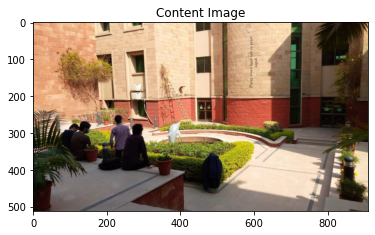

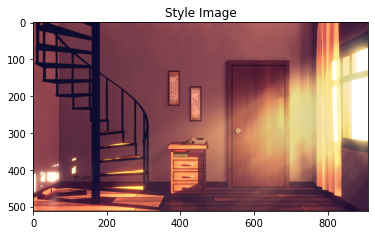

In [7]:
#Converting tensor back to PIL image.
unloader = transforms.ToPILImage()

def get_pil_image(tensor):
    image = tensor.cpu().clone() 
    image = image.squeeze(0)
    image = unloader(image)

    return image

def display_image(tensor, title=None):
    image = get_pil_image(tensor)

    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display_image(content_img, title='Content Image')

plt.figure()
display_image(style_img, title='Style Image')


Computing L2 loss for the image content

In [8]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

Computing the gram matrix for style loss

In [9]:
def gram_matrix(input):
    a, k, n, m = input.size()  
    #a = batch size (1)
    #k = number of feature maps at layer L.
    #n, m = dimensions of a feature map

    features = input.view(a * k, n * m)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    #Normalizing and returning the gram matrix.
    return G.div(a * k * n * m)

In [10]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        g_matrix = gram_matrix(input)
        self.loss = F.mse_loss(g_matrix, self.target)
        return input

Importing pretrained vgg19 model to be used for style transfer

In [11]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Normalizing the images by mean (0.485, 0.456, 0.406) and standard deviation (0.229, 0.224, 0.225) as used in vgg19

In [12]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

#Creating a module to normalize mean and std.
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [13]:
#Using 4th convolutional layer for content loss. 
content_layers_default = ['conv_4']

#Using convolutional layer 1, 2, 3, 4 and 5 for style loss.
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

#Returns the model, content loss and style loss.
def get_model_and_losses(cnn, normalization_mean, 
                               normalization_std, style_img,
                               content_img, 
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
  
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        #Computing content loss for conv_2d only.
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        #Computing losses for conv 1, 2, 3, 4 and 5d only.
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Using the content image as it is for input


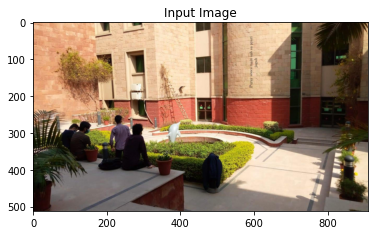

In [14]:
input_img = content_img.clone()

plt.figure()
display_image(input_img, title='Input Image')

Using L-BFGS for optimizing loss functions as per the original paper by Gatys et al.

In [15]:
def get_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [16]:
def style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, iterations=300,
                       alpha=1, beta=1000000):
    
    #alpha = content_weight
    #beta = style_weight
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    
    #Setting input_img to be optimized rather than the model weights.
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= iterations:

        def closure():
            with torch.no_grad():
                #Clipping image values to be between 0 and 1 i.e the tensor range for pytorch.
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for style_loss in style_losses:
                style_score += style_loss.loss
            for content_loss in content_losses:
                content_score += content_loss.loss

            content_score *= alpha
            style_score *= beta

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    #Clipping image values to be between 0 and 1 i.e the tensor range for pytorch.
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Finally, we can run the algorithm.




In [17]:
result = style_transfer(cnn, normalization_mean, normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


run [50]:
Style Loss : 55.292770 Content Loss: 10.320192

run [100]:
Style Loss : 14.031867 Content Loss: 11.285952

run [150]:
Style Loss : 7.268835 Content Loss: 10.593448

run [200]:
Style Loss : 4.348569 Content Loss: 10.009434

run [250]:
Style Loss : 3.064898 Content Loss: 9.523862

run [300]:
Style Loss : 2.303415 Content Loss: 9.203651



In [18]:
image = get_pil_image(result)

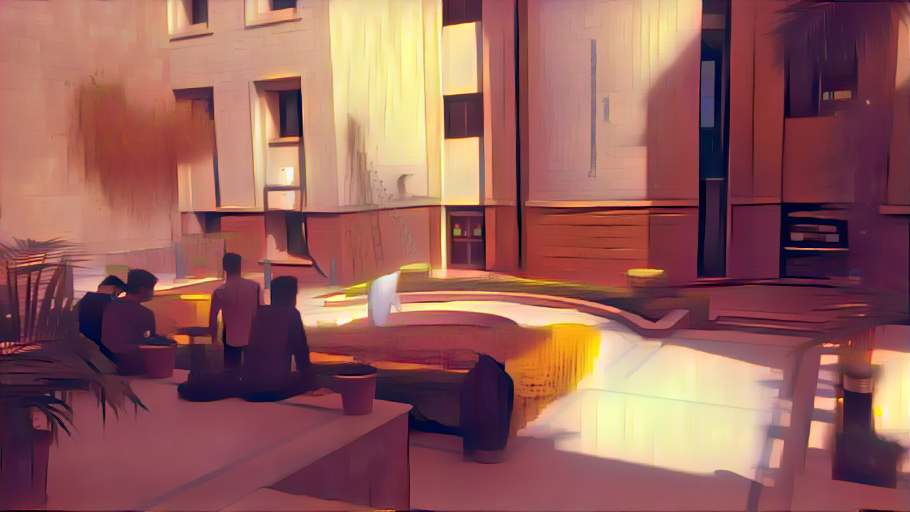

In [19]:
image

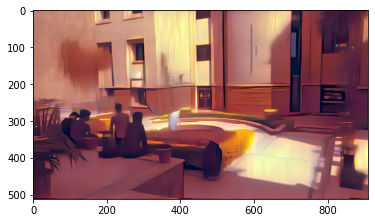

In [20]:
display_image(result)

## Result of style image test 1

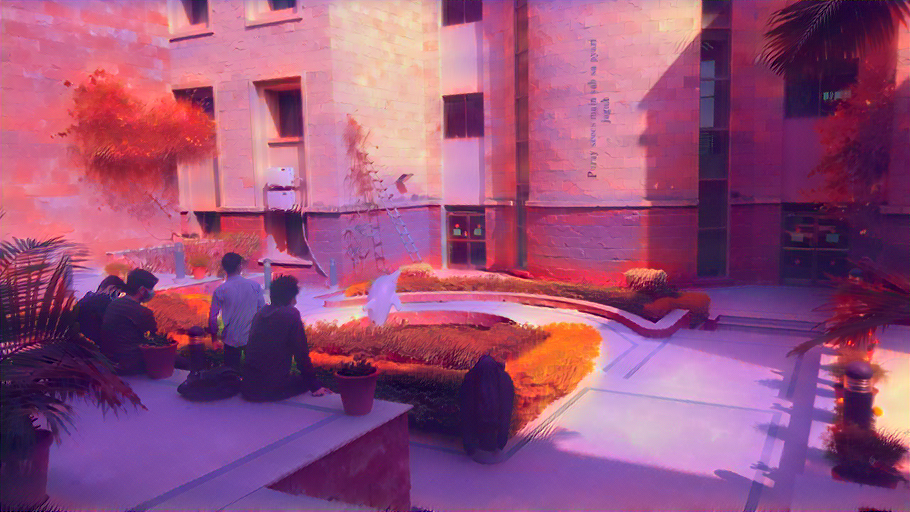

In [ ]:
image

## Result of style image test 2

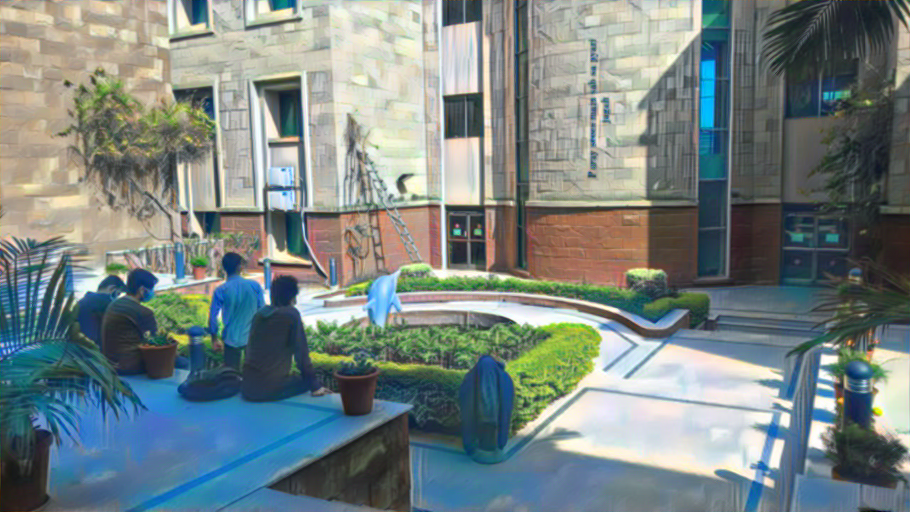

In [ ]:
image

## Result of style image test 3

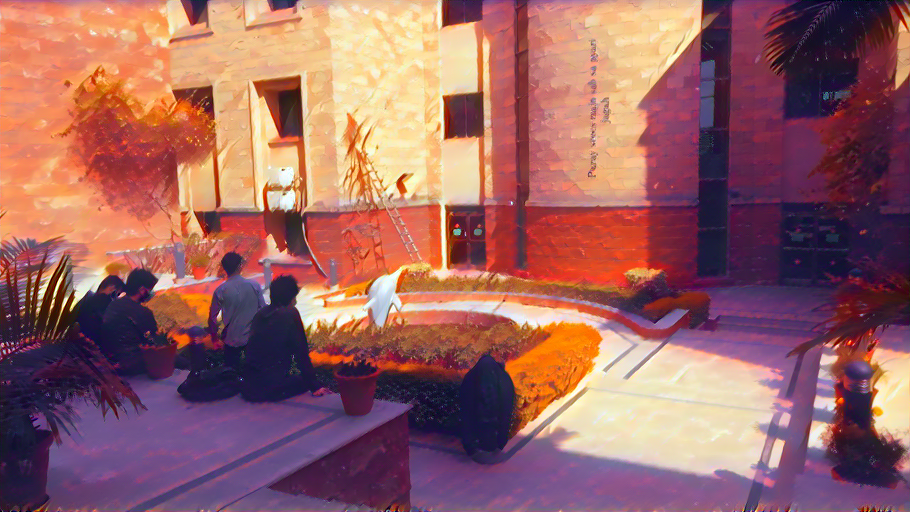

In [ ]:
image

## Result of style image test 4



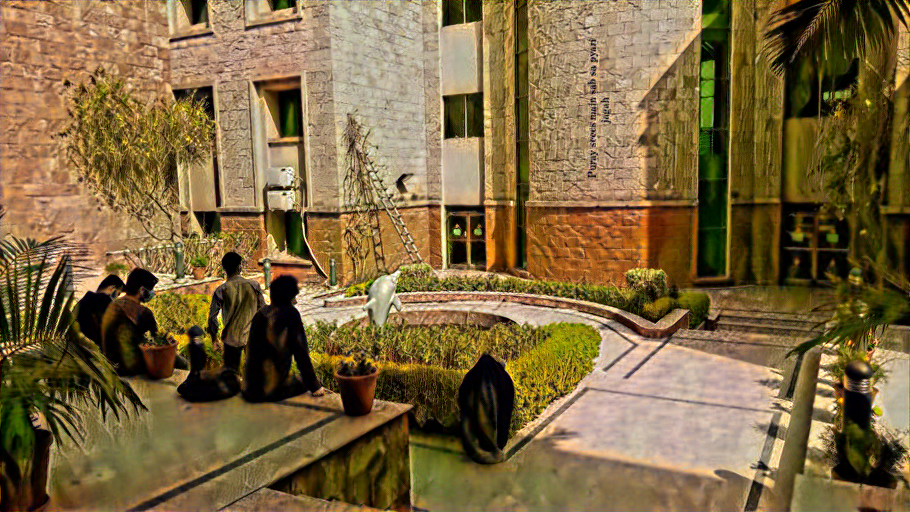

In [ ]:
image

## Result of style image test 5

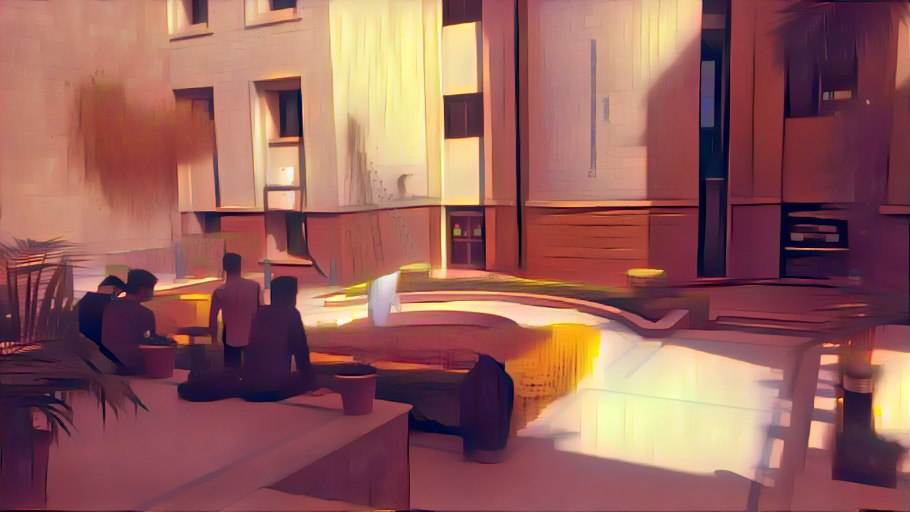

In [ ]:
image